<a href="https://colab.research.google.com/github/dude123studios/AdvancedDeepLearning/blob/main/DCGAN_for_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape,UpSampling2D, Conv2D, BatchNormalization, Activation, LeakyReLU,Dropout,ZeroPadding2D,Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt


Lets define our **DCGAN** class

In [4]:
class DCGAN:

  def __init__(self,rows,cols,channels,z=100):
    self.img_rows = rows
    self.img_cols = cols
    self.channels = channels
    self.img_shape = (self.img_rows,self.img_cols,self.channels)
    self.latent_dim = z

    optimizer = Adam(0.0002,0.5)

    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

    self.generator = self.build_generator()

    z = Input(shape=(self.latent_dim,))
    img = self.generator(z)

    self.discriminator.trainable = False

    valid = self.discriminator(img)
    self.combined = Model(z,valid)
    self.combined.compile(loss='binary_crossentropy',optimizer=optimizer)

  def build_generator(self):
    '''
    Note*
    I can use the TransposedConvolution2D layer instead, to learn upsampling, rather than just using standard upsampling
    with bed of nails of padding, however it is more computationally expensive 
    '''
    model = Sequential()
    model.add(Dense(128*7*7,activation='relu',input_dim=self.latent_dim))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(UpSampling2D())
    model.add(Conv2D(64,kernel_size=3,padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation('relu'))
    model.add(Conv2D(self.channels,kernel_size=3,padding='same'))
    model.add(Activation('tanh'))
    model.summary()
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    return Model(inputs=noise,outputs=img)
  
  def build_discriminator(self):
    model = Sequential()

    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=self.img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64,kernel_size=3,strides=2,padding='same'))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256,kernel_size=3,strides=2,padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    img = Input(shape=self.img_shape)
    validity = model(img)
    return Model(inputs=img,outputs=validity)


  def train(self,epochs,batch_size=128,save_interval=50):
    (X_train, _), (_,_) = mnist.load_data()

    X_train = X_train/127.5 -1
    X_train = np.expand_dims(X_train,axis=3)

    valid = np.ones((batch_size,1))
    fake = np.zeros((batch_size,1))

    for epoch in range(epochs):
      idx = np.random.randint(0,X_train.shape[0],batch_size)
      imgs = X_train[idx]

      noise = np.random.normal(0,1,(batch_size,self.latent_dim))
      gen_imgs = self.generator.predict(noise)

      self.discriminator.trainable = True
      d_loss_real = self.discriminator.train_on_batch(imgs,valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs,fake)
      d_loss = 0.5 * np.add(d_loss_fake,d_loss_real)
      self.discriminator.trainable = False

      g_loss = self.combined.train_on_batch(noise,valid)
      if epoch % 50 == 0:
        print('%d [D loss: %f, acc.: %.2f] [G loss: %f]' %(epoch,d_loss[0],100*d_loss[1],g_loss))

      if epoch % save_interval == 0:
        self.save_imgs(epoch)

  def save_imgs(self,epoch):
    r,c = 5,5
    noise = np.random.normal(0,1,(r*c,self.latent_dim))
    gen_imgs = self.generator.predict(noise)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axis = plt.subplots(r,c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axis[i,j].imshow(gen_imgs[cnt,:,:,0],cmap='gray')
        axis[i,j].axis('off')
        cnt+=1
    fig.savefig('images/dcgan_mnist_%d.png' % epoch)
    plt.close()


Finally, lets train our gan with a **GPU**

In [6]:
with tf.device('gpu:0'):
  dcgan = DCGAN(28,28,1)
  dcgan.train(epochs=5000,batch_size=32,save_interval=1000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 64)         

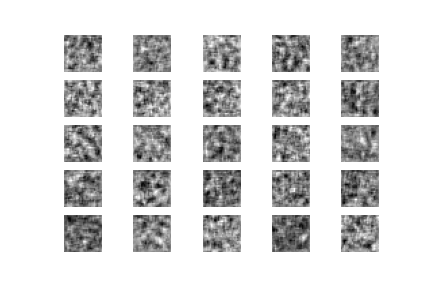

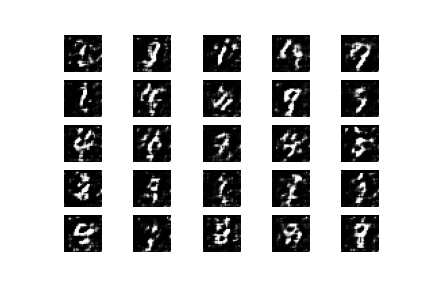

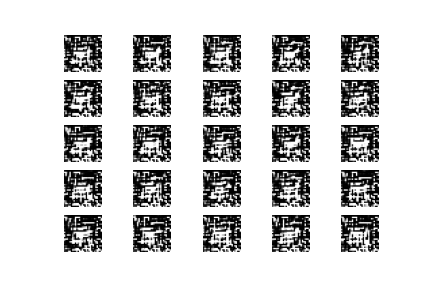

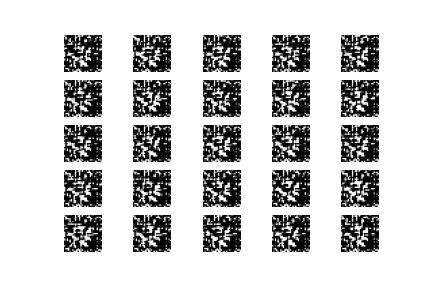

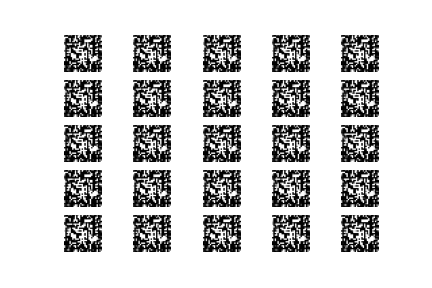

Look at how the Generator learned over time